# Modeles de Gradient boosting 

In [353]:
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
import pandas as pd
import numpy as np
py.init_notebook_mode(connected=True)
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

In [324]:
def plot_optimisation(train, test, parameter, parameter_name):
    train_trace = go.Scatter(
        x = train,
        y = parameter,
        mode = 'lines',
        name = 'train_scores'
    )
    test_trace = go.Scatter(
        x = test,
        y = parameter,
        mode = 'lines',
        name = 'test_scores'
    )

    data = [train_trace, test_trace]

    layout= go.Layout(
        title= 'Train et Test scores en fonction du '+parameter_name,
        xaxis= dict(title= 'Scores'),
        yaxis=dict(title= parameter_name),
        showlegend= True
    )
    fig= go.Figure(data=data, layout=layout)
    py.iplot(fig)    

In [447]:
raw = pd.read_csv('data/kc_house_data.csv')
raw[['floors', 'zipcode']] = pd.DataFrame(
    {
        'floors': [floor.replace("'","") for floor in raw.floors.values],
        'zipcode': [code.replace("'","") for code in raw.zipcode.values]
    }, dtype='float32')
raw['date'] = pd.to_datetime(raw['date'])
raw['month'] = pd.DatetimeIndex(raw.loc[:,'date']).month
raw['year'] = pd.DatetimeIndex(raw.loc[:,'date']).year
raw['day'] = pd.DatetimeIndex(raw.loc[:,'date']).day
raw = raw[['id',
 'price',
 'date',
 'year',
 'month',
 'day',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
]]
data = {
    feature: raw[feature].values for feature in raw.columns[3:]
}

X = pd.DataFrame(
    data=data,
    index=raw['id'].values, 
)
y = pd.DataFrame(
    raw.price.values,
    columns=['price'],
    index=raw['id'].values, 
)

In [326]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=0)

## Dummy Estimator

In [349]:
from sklearn.dummy import DummyRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=0)

strategies = ['mean','median','quantile']
for strategy in strategies:
    reg = DummyRegressor(strategy=strategy, constant=1000, quantile=0.5)
    reg.fit(X_train, y_train)
    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)

    print('strategy : {}\tTrain score : {}\tTest score : {}'
          .format(strategy,train_score, test_score))

strategy : mean	Train score : 0.0	Test score : -4.9430475934642004e-08
strategy : median	Train score : -0.062392826079634256	Test score : -0.056244074408103195
strategy : quantile	Train score : -0.062392826079634256	Test score : -0.056244074408103195


## AdaBoost

In [351]:
import numpy as np
from sklearn.ensemble import AdaBoostRegressor

# Create the dataset
rng = np.random.RandomState(1)

reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),
                          n_estimators=500, random_state=rng)
reg.fit(X_train, y_train.price.values)

train_score = reg.score(X_train, y_train.price.values)
test_score = reg.score(X_test, y_test.price.values)

print('Train score : {}\tTest score : {}'
      .format(round(train_score,5), round(test_score,5)))

Train score : 0.59374	Test score : 0.55199


## Gradient Tree Boosting

### Selection de la meilleure fonction cout

In [155]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Fit regression model
loss_functions = ['ls', 'lad', 'huber', 'quantile']
train_scores =[]
test_scores=[]

for fct in loss_functions:
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': fct}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    train_scores.append(round(train_score, 6))        
    test_scores.append(round(test_score, 6))        

plot_optimisation(train_scores, test_scores, n_estimators, 'loss_function') 

### Selection du meilleur nombre d'iteration

In [154]:
n_estimators =[]
train_scores =[]
test_scores=[]

for n in [10, 50, 100, 500, 1000]:
    params = {'n_estimators': n, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls'}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    n_estimators.append(n)
    train_scores.append(round(train_score, 6))        
    test_scores.append(round(test_score, 6))        

plot_optimisation(train_scores, test_scores, n_estimators, 'n_estimators') 

In [159]:
min_samples_splits =[]
train_scores =[]
test_scores=[]

for n in np.arange(2, 10, 1):
    params = {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': n,
              'learning_rate': 0.01, 'loss': 'ls'}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    min_samples_splits.append(n)
    train_scores.append(train_score)        
    test_scores.append(test_score)    
    
plot_optimisation(train_scores, test_scores, min_samples_splits, 'min_samples_split') 

In [158]:
min_samples_splits

[2, 3]

In [185]:
rates =[]
train_scores =[]
test_scores=[]

for rate in np.arange(0.01, 1, 0.05):
    params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': rate, 'loss': 'ls'}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    rates.append(rate)
    train_scores.append(train_score)        
    test_scores.append(test_score)    
    
plot_optimisation(train_scores, test_scores, rates, 'Learning_rate')     


In [186]:
max_depths =[]
train_scores =[]
test_scores=[]

for n in np.arange(3, 10, 1):
    params = {'n_estimators': 100, 'max_depth': n, 'min_samples_split': 2,
              'learning_rate': 0.16, 'loss': 'ls'}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    max_depths.append(n)
    train_scores.append(train_score)        
    test_scores.append(test_score)    
    
plot_optimisation(train_scores, test_scores, max_depths, 'max_depth')     


In [187]:
subsamples =[]
train_scores =[]
test_scores=[]

for n in np.arange(0.1, 1, 0.2):
    params = {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2,
              'learning_rate': 0.16, 'loss': 'ls', 'subsample': n}

    reg = ensemble.GradientBoostingRegressor(**params)

    reg.fit(X_train, y_train.price.values)

    train_score = reg.score(X_train, y_train.price.values)
    test_score = reg.score(X_test, y_test.price.values)
    subsamples.append(n)
    train_scores.append(train_score)        
    test_scores.append(test_score)    
    
plot_optimisation(train_scores, test_scores, subsamples, 'max_depth')     

### Meilleurs parametres

In [449]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.16, 'loss': 'ls', 'subsample': 0.5}

reg = ensemble.GradientBoostingRegressor(**params)

reg.fit(X_train, y_train.price.values)

train_score = reg.score(X_train, y_train.price.values)
test_score = reg.score(X_test, y_test.price.values)

print('Train score : {}\tTest score : {}'
      .format(round(train_score,5), round(test_score,5)))

Train score : 0.98446	Test score : 0.89571


In [330]:
from sklearn.metrics import *
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test, reg.predict(X_test))
evs = explained_variance_score(y_test, reg.predict(X_test))
msle = mean_squared_log_error(y_test, reg.predict(X_test))
median_ae = median_absolute_error(y_test, reg.predict(X_test))
r2_score = r2_score(y_test, reg.predict(X_test))

In [332]:
pd.DataFrame(data=[mse, mae, evs,msle,median_ae,r2_score])

,0
0,1.288177e+10
1,6.392279e+04
2,8.916968e-01
3,3.478988e-02
4,3.728295e+04
5,8.916809e-01


In [216]:
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

data = [go.Bar(
            x=feature_importance[sorted_idx],
            y=X.columns[sorted_idx],
            orientation = 'h'
)]

py.iplot(data, filename='horizontal-bar')

Training GBRT...


/home/djamel/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



 done.
Convenience plot with ``partial_dependence_plots``
Custom 3d plot via ``partial_dependence``


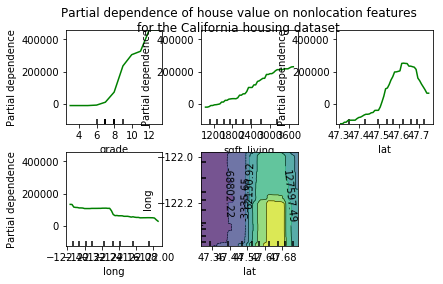

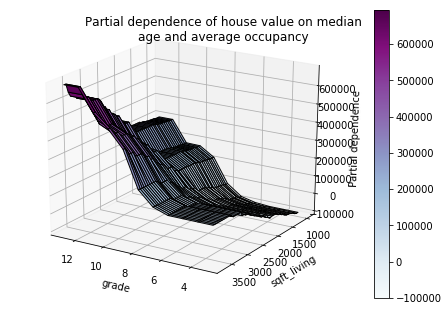

In [308]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

def main():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    names = X.columns

    print("Training GBRT...")
    clf = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                    learning_rate=0.1, loss='huber',
                                    random_state=1)
    clf.fit(X_train, y_train)
    print(" done.")

    print('Convenience plot with ``partial_dependence_plots``')

    features = [11, 5, 17, 18, (17, 18)]
    fig, axs = plot_partial_dependence(clf, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, grid_resolution=50)
    fig.suptitle('Partial dependence of house value on nonlocation features\n'
                 'for the California housing dataset')
    plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

    print('Custom 3d plot via ``partial_dependence``')
    fig = plt.figure()

    target_feature = (11, 5)
    pdp, axes = partial_dependence(clf, target_feature,
                                   X=X_train, grid_resolution=50)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].reshape(list(map(np.size, axes))).T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                           cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(names[target_feature[0]])
    ax.set_ylabel(names[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence of house value on median\n'
                 'age and average occupancy')
    plt.subplots_adjust(top=0.9)

    plt.show()

if __name__ == '__main__':
    main()

# Enrichissement du dataset

In [545]:
import requests

data_new = pd.read_csv(
    'https://raw.githubusercontent.com/degharbi/Housing-prices-prediction/master/data/data_new.csv', 
    index_col='id',
)
data_new.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
6123415060,'','',3.0,2.00,1810.0,6198.0,'','','','','','','',-1,'',u'98177',477.71335,-122.358212,'',''
7488078255,'','',4.0,4.00,3080.0,36154.0,'','','','','','','',-1,'',u'98027',474.67851,-122.010550,'',''
9844329224,'','',2.0,1.00,690.0,4721.0,'','','','','','','',-1,'',u'98106',475.24554,-122.358143,'',''
588296013,'','',4.0,2.75,2250.0,17859.0,'','','','','','','',-1,'',u'98058',474.55769,-122.088972,'',''
4549248854,'','',4.0,5.00,4930.0,10454.0,'','','','','','','',-1,'',u'98040',475.31001,-122.218613,'',''


In [548]:
data_new['date'] = pd.to_datetime(raw['date'])
data_new['year']= raw.year.median()
data_new['month']= raw.day.median()  
data_new['day']= raw.month.median()
data_new['floors']= raw.floors.median()
data_new['waterfront']= raw.waterfront.median()
data_new['view']= raw.view.median()
data_new['condition']= raw.condition.median()
data_new['grade']= raw.grade.median()
data_new['sqft_above']= raw.sqft_above.median()
data_new['sqft_basement']= raw.sqft_basement.median()
data_new['yr_built']= raw.yr_built.median()
data_new['yr_renovated']= raw.yr_renovated.median()
data_new['sqft_living15']= raw.sqft_living15.median()
data_new['sqft_lot15']= raw.sqft_lot15.median()

In [546]:
data_new['zipcode'] = pd.DataFrame(
    {
        'zipcode': [code.replace('u','').strip().replace('"','').replace("'",'') for code in data_new.zipcode.values]
    }).values

In [549]:
data_new.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
id,,,,,,,,,,,,,,,,,,,,,
6123415060,NaT,'',3.0,2.00,1810.0,6198.0,1.5,0.0,0.0,3.0,...,1975.0,0.0,98177,477.71335,-122.358212,1840.0,7620.0,2014.0,16.0,6.0
7488078255,NaT,'',4.0,4.00,3080.0,36154.0,1.5,0.0,0.0,3.0,...,1975.0,0.0,98027,474.67851,-122.010550,1840.0,7620.0,2014.0,16.0,6.0
9844329224,NaT,'',2.0,1.00,690.0,4721.0,1.5,0.0,0.0,3.0,...,1975.0,0.0,98106,475.24554,-122.358143,1840.0,7620.0,2014.0,16.0,6.0
588296013,NaT,'',4.0,2.75,2250.0,17859.0,1.5,0.0,0.0,3.0,...,1975.0,0.0,98058,474.55769,-122.088972,1840.0,7620.0,2014.0,16.0,6.0
4549248854,NaT,'',4.0,5.00,4930.0,10454.0,1.5,0.0,0.0,3.0,...,1975.0,0.0,98040,475.31001,-122.218613,1840.0,7620.0,2014.0,16.0,6.0


In [550]:
data_new = data_new[['price',
 'date',
 'year',
 'month',
 'day',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
]]
data = {
    feature: data_new[feature].values for feature in data_new.columns[2:]
}

In [551]:
X_new = pd.DataFrame(
    data=data,
    index=data_new.index.values, 
)

In [552]:
X_new.head()

,year,month,day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6123415060,2014.0,16.0,6.0,3.0,2.00,1810.0,6198.0,1.5,0.0,0.0,...,7.0,1560.0,0.0,1975.0,0.0,98177,477.71335,-122.358212,1840.0,7620.0
7488078255,2014.0,16.0,6.0,4.0,4.00,3080.0,36154.0,1.5,0.0,0.0,...,7.0,1560.0,0.0,1975.0,0.0,98027,474.67851,-122.010550,1840.0,7620.0
9844329224,2014.0,16.0,6.0,2.0,1.00,690.0,4721.0,1.5,0.0,0.0,...,7.0,1560.0,0.0,1975.0,0.0,98106,475.24554,-122.358143,1840.0,7620.0
588296013,2014.0,16.0,6.0,4.0,2.75,2250.0,17859.0,1.5,0.0,0.0,...,7.0,1560.0,0.0,1975.0,0.0,98058,474.55769,-122.088972,1840.0,7620.0
4549248854,2014.0,16.0,6.0,4.0,5.00,4930.0,10454.0,1.5,0.0,0.0,...,7.0,1560.0,0.0,1975.0,0.0,98040,475.31001,-122.218613,1840.0,7620.0


In [553]:
y_new = reg.predict(X_new)

In [570]:
data_new['price'] = y_new
data_new.head()

,price,date,year,month,day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,,
6123415060,366870.205566,NaT,2014.0,16.0,6.0,3.0,2.00,1810.0,6198.0,1.5,...,7.0,1560.0,0.0,1975.0,0.0,98177,477.71335,-122.358212,1840.0,7620.0
7488078255,461875.351704,NaT,2014.0,16.0,6.0,4.0,4.00,3080.0,36154.0,1.5,...,7.0,1560.0,0.0,1975.0,0.0,98027,474.67851,-122.010550,1840.0,7620.0
9844329224,283626.979774,NaT,2014.0,16.0,6.0,2.0,1.00,690.0,4721.0,1.5,...,7.0,1560.0,0.0,1975.0,0.0,98106,475.24554,-122.358143,1840.0,7620.0
588296013,374749.384546,NaT,2014.0,16.0,6.0,4.0,2.75,2250.0,17859.0,1.5,...,7.0,1560.0,0.0,1975.0,0.0,98058,474.55769,-122.088972,1840.0,7620.0
4549248854,570187.030761,NaT,2014.0,16.0,6.0,4.0,5.00,4930.0,10454.0,1.5,...,7.0,1560.0,0.0,1975.0,0.0,98040,475.31001,-122.218613,1840.0,7620.0


In [582]:
new_trace = go.Scatter(
    x = data_new.sqft_living.values,
    y = data_new.price.values,
    mode = 'markers',
    name= 'new data'
)
old_trace = go.Scatter(
    x = X.sqft_living.values,
    y = y.price.values,
    mode = 'markers',
    name= 'old data'
)

data = [old_trace, new_trace]

layout= go.Layout(
    title= 'Prix en fonction de la surface',
    xaxis= dict(title= 'surface'),
    yaxis=dict(title= 'prix'),
)
fig= go.Figure(data=data, layout=layout)
py.iplot(fig)  